# Sequences Scrapping Automatically
This notebook is an automated tool designed for retrieving 16S rRNA sequences from the GenBank database, managed by the National Center for Biotechnology Information (NCBI). The focus is on sequences associated with various genera found in water bodies, as part of a broader study.

# Key Steps and Features:
### Reading Genera List:

The script starts by reading a list of genera from an Excel file. These genera are of particular interest for the study.
### NCBI Database Interaction:

It establishes a connection with the NCBI database and iteratively queries each genus. This process involves fetching the unique identifiers (accession numbers) of the relevant 16S rRNA sequences.
### Data Storage and Organization:

The retrieved data, mainly accession numbers, are stored in a dictionary for subsequent processing.
### Sequence Retrieval and Verification:

The notebook includes a function for fetching the actual sequence data from GenBank using the accession numbers. There's also a provision for validating the retrieved sequences.
### Data Manipulation:

Extensive data manipulation is performed, including transforming and merging dataframes to align the sequence data with the original genera list.
### Phylogenetic Analysis:

The primary goal is to align these sequences to construct a dendrogram, offering insights into the genomic relationships among the genera.
The notebook implements the UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method for tree construction, with a mention of the possibility of using Neighbor-Joining (NJ).
The script includes steps for sequence alignment, conversion to FASTA format, and preparation for phylogenetic tree construction.
### Bootstrap Analysis for Tree Reliability:

To assess the reliability of the phylogenetic trees, a bootstrap analysis is performed. This involves generating multiple pseudo-replicated datasets and analyzing the resulting tree structures.
### Consensus Tree Construction:

A consensus tree is constructed from the bootstrap trees, providing a robust representation of the phylogenetic relationships.
### Additional Notes:
The script contains several safety and optimization measures, such as using time.sleep to avoid overloading the NCBI server and handling exceptions during sequence retrieval.
There's a focus on improving the script, including suggestions for secure API key storage, error handling enhancements, and code documentation.

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

In [2]:
from google.colab import drive  #silence for vscode
drive.mount('/content/drive')
import pandas as pd
import os

#change the bloody path
os.chdir('/content/drive/My Drive/MIC')

Mounted at /content/drive


In [3]:
# for colab
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.4 MB/s eta 0:00:00


In [4]:
# Importing the necesary libraries
from Bio import Entrez
import time
import pandas as pd

In [5]:
%%writefile config.py
NCBI_EMAIL = "wattsbeatrizamanda@gmail.com"
NCBI_API_KEY = "01d2f369faef0e78cd4906063672fab7c809"

Writing config.py


In [ ]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY

'# Comunicating with the NCBI\nfrom config import NCBI_API_KEY, NCBI_EMAIL\nEntrez.email = NCBI_EMAIL\nEntrez.api_key = NCBI_API_KEY'

In [100]:
# Read the Excel file
selected = pd.read_excel("data/df_after_pca.xlsx", sheet_name='selected', header=[0,1,2,3,4,5,6,7])
# Promote the first row as the header and fix the MultiIndex structure
new_header = [
    tuple(selected.iloc[0, :].fillna('').values)
]  # Convert to a list of tuples

# Rebuild the MultiIndex columns
selected.columns = pd.MultiIndex.from_tuples(new_header, names=selected.columns.names)


ValueError: Length of names must match number of levels in MultiIndex.

In [98]:
print(selected.head())

  Unnamed: 0_level_0           Category Rhodocyclales_Rhodocyclaceae_Azospira  \
  Unnamed: 0_level_1 Unnamed: 1_level_1                              Bacteria   
  Unnamed: 0_level_2 Unnamed: 1_level_2                        Proteobacteria   
  Unnamed: 0_level_3 Unnamed: 1_level_3                    Betaproteobacteria   
  Unnamed: 0_level_4 Unnamed: 1_level_4                         Rhodocyclales   
  Unnamed: 0_level_5 Unnamed: 1_level_5                        Rhodocyclaceae   
  Unnamed: 0_level_6 Unnamed: 1_level_6                              Azospira   
  Unnamed: 0_level_7 Unnamed: 1_level_7                                   110   
0              Sites                NaN                                   NaN   
1             site_1                3.0                             26.928048   
2             site_2                1.0                              1.859230   
3             site_3                1.0                              3.093543   
4             site_4        

In [94]:
# Read the Excel file
selected = pd.read_excel("data/df_after_pca.xlsx", sheet_name='selected', header=[0,1,2,3,4,5,6,7])
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))

selected.columns = pd.MultiIndex.from_tuples(
    selected.columns,
    names=['Sites', 'Category', '', '', '', '', '', '']
)

# Ensure 'Sites' and 'Category' columns are of the correct types
selected[('Sites', '', '', '', '', '', '', '')] = selected[('Sites', '', '', '', '', '', '', '')].astype(str)
selected[('Category', '', '', '', '', '', '', '')] = selected[('Category', '', '', '', '', '', '', '')].astype(int)

# If required, reset or reorder levels
#selected = selected.sort_index(axis=1)  # Sort columns by index if needed

KeyError: ('Sites', '', '', '', '', '', '', '')

In [ ]:
# Get the current column levels
levels = selected.columns.levels

# Replace the first level name with 'Sites'
levels = [levels[0].set_labels(selected.columns.levels[0].labels), levels[1].set_labels(selected.columns.levels[1].labels),levels[2].set_labels(selected.columns.levels[2].labels), levels[3].set_labels(selected.columns.levels[3].labels), levels[4].set_labels(selected.columns.levels[4].labels), levels[5].set_labels(selected.columns.levels[5].labels),levels[6].set_labels(selected.columns.levels[6].labels), levels[7].set_labels(selected.columns.levels[7].labels)]


levels[0] = levels[0].set_names(['Sites'])

In [90]:
selected.columns

MultiIndex([(                                      'Unnamed: 0_level_0', ...),
            (                                                'Category', ...),
            (                   'Rhodocyclales_Rhodocyclaceae_Azospira', ...),
            (        'Actinomycetales_Dermabacteraceae_Brachybacterium', ...),
            (        'Erysipelotrichales_Erysipelotrichaceae_Bulleidia', ...),
            ('Actinomycetales_Promicromonosporaceae_Cellulosimicrobium', ...),
            (                'Clostridiales_Clostridiaceae_Clostridium', ...),
            (      'Actinomycetales_Corynebacteriaceae_Corynebacterium', ...),
            (              'Oceanospirillales_Halomonadaceae_Halomonas', ...),
            (                 'Legionellales_Legionellaceae_Legionella', ...),
            (              'Caulobacterales_Caulobacteraceae_Mycoplana', ...),
            (             'Actinomycetales_Cellulomonadaceae_Oerskovia', ...),
            (                  'Clostridiales_Clostr

In [ ]:
# Extract Genera from the multi-index
genera = df.columns.get_level_values(5).to_list()

# Dictionary to store the results
results = {}

If necesary it is possible to retrieve only the wild strains and water environments like this
```search_term = f"{genus}[Orgn] AND 16S rRNA[Gene] AND wild[Properties] AND water[Environment]"
```

I silence the following code so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [ ]:
# Loop over the genera names
for genus in genera:
    search_term = f"{genus}[Orgn] AND 16S rRNA[Gene]"
    handle = Entrez.esearch(db="nucleotide", term=search_term)
    record = Entrez.read(handle)
    results[genus] = record["IdList"]
    time.sleep(10)  # pause for 10 seconds

In [ ]:
# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")

Unnamed: 2_level_5: []
Clostridium: ['2318625970', '2318619396', '2318616155', '2318612385', '2318612293', '2318612166', '2318611699', '2318611547', '2318611484', '2303472194', '2283786000', '2055419549', '820660841', '820660837', '820660834', '1868669465', '381140144', '1778013553', '1778013552', '1547055218']
Corynebacterium: ['2318612267', '2306632722', '2302170227', '2278607924', '2265463538', '2104758927', '1962359378', '1962356581', '1962355919', '1962354668', '1962354582', '1962354512', '1962354456', '1962354305', '1962354283', '1962354064', '1885913355', '1862966248', '1862966247', '1731305085']
Gelria: ['1079707064', '1079706967', '1079706893', '1079706636', '1079706380', '1079706360', '1041791969', '1041791968', '192805173', '192805041']
Haemophilus: ['2318645546', '2318643245', '2318638413', '2318626163', '2318625369', '2318619100', '2318612974', '2318612841', '2318611712', '2318611661', '2318611096', '2278607975', '2105486964', '2105486925', '1962355866', '1269612706', '113

In [ ]:
# Create a DataFrame from the dictionary
df_sequences = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_sequences.head(16)

,Genus,IDs
0,Unnamed: 2_level_5,[]
1,Clostridium,"[2318625970, 2318619396, 2318616155, 231861238..."
2,Corynebacterium,"[2318612267, 2306632722, 2302170227, 227860792..."
3,Gelria,"[1079707064, 1079706967, 1079706893, 107970663..."
4,Haemophilus,"[2318645546, 2318643245, 2318638413, 231862616..."
5,Halomonas,"[2295461564, 2295461558, 2295461554, 229546144..."
6,Legionella,"[1985648187, 1985648149, 1985648080, 198564795..."
7,Oerskovia,"[1041788013, 1041788012, 1008904215, 954166227..."
8,Oxobacter,"[671695952, 671695951, 671695950, 671695949, 5..."
9,Porphyromonas,"[2533078098, 2318627553, 2318613723, 231861226..."


In [ ]:
df.head()

,Category,Clostridiales_Clostridiaceae_Clostridium,Actinomycetales_Corynebacteriaceae_Corynebacterium,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Pasteurellales_Pasteurellaceae_Haemophilus,Oceanospirillales_Halomonadaceae_Halomonas,Legionellales_Legionellaceae_Legionella,Actinomycetales_Cellulomonadaceae_Oerskovia,Clostridiales_Clostridiaceae_Oxobacter,Bacteroidales_Porphyromonadaceae_Porphyromonas,Erysipelotrichales_Erysipelotrichaceae_Psb-m-3,Actinomycetales_Micrococcaceae_Pseudarthrobacter,Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas,Xanthomonadale_Paracoccaceae_Rhodobacter,Burkholderiales_Comamonadaceae_Roseateles,Rhodospirillales_Acetobacteraceae_Roseococcus
,Unnamed: 2_level_1,Firmicutes,Actinobacteria,Firmicutes,Proteobacteria,Proteobacteria,Proteobacteria,Actinobacteria,Firmicutes,Bacteroidetes,Firmicutes,Actinobacteria,Proteobacteria,Pseudomonadota,Proteobacteria,Proteobacteria
,Unnamed: 2_level_2,Clostridia,Actinobacteria,Clostridia,Gammaproteobacteria,Gammaproteobacteria,Gammaproteobacteria,Actinobacteria,Clostridia,Bacteroidia,Erysipelotrichi,Actinobacteria,Gammaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Alphaproteobacteria
,Unnamed: 2_level_3,Clostridiales,Actinomycetales,Thermoanaerobacterales,Pasteurellales,Oceanospirillales,Legionellales,Actinomycetales,Clostridiales,Bacteroidales,Erysipelotrichales,Actinomycetales,Vibrionales,Xanthomonadale,Burkholderiales,Rhodospirillales
,Unnamed: 2_level_4,Clostridiaceae,Corynebacteriaceae,Thermoanaerobacteraceae,Pasteurellaceae,Halomonadaceae,Legionellaceae,Cellulomonadaceae,Clostridiaceae,Porphyromonadaceae,Erysipelotrichaceae,Micrococcaceae,Pseudoalteromonadaceae,Paracoccaceae,Comamonadaceae,Acetobacteraceae
,Unnamed: 2_level_5,Clostridium,Corynebacterium,Gelria,Haemophilus,Halomonas,Legionella,Oerskovia,Oxobacter,Porphyromonas,Psb-m-3,Pseudarthrobacter,Pseudoalteromonas,Rhodobacter,Roseateles,Roseococcus
,Unnamed: 2_level_6,214,229,334,351,354,408,497,512,565,581,583,584,606,621,625
Sites,,,,,,,,,,,,,,,,
site_1,3.0,0.0,0.000000,0.021542,0.473934,0.000000,0.000000,0.0,0.0,0.172340,0.0,0.0,0.0,0.0,0.0,0.000000
site_2,1.0,0.0,0.000000,0.000000,0.626067,0.000000,0.000000,0.0,0.0,0.246633,0.0,0.0,0.0,0.0,0.0,0.000000
site_3,1.0,0.0,0.000000,0.000000,0.429659,0.024552,0.000000,0.0,0.0,1.485392,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
selected = df.T
selected = selected.reset_index()
selected.head()

Sites,level_0,level_1,level_2,level_3,level_4,level_5,level_6,site_1,site_2,site_3,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
0,Category,Unnamed: 2_level_1,Unnamed: 2_level_2,Unnamed: 2_level_3,Unnamed: 2_level_4,Unnamed: 2_level_5,Unnamed: 2_level_6,3.000000,1.000000,1.000000,...,2.0,2.000000,2.000000,2.0,2.000000,2.0,3.0,3.0,1.0,1.0
1,Clostridiales_Clostridiaceae_Clostridium,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,214,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.544366,0.0,0.0,0.0,0.0,0.0
2,Actinomycetales_Corynebacteriaceae_Corynebacte...,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,229,0.000000,0.000000,0.000000,...,0.0,0.004361,0.000000,0.0,0.272183,0.0,0.0,0.0,0.0,0.0
3,Thermoanaerobacterales_Thermoanaerobacteraceae...,Firmicutes,Clostridia,Thermoanaerobacterales,Thermoanaerobacteraceae,Gelria,334,0.021542,0.000000,0.000000,...,0.0,0.047972,0.023116,0.0,0.000000,0.0,0.0,0.0,0.0,2.3
4,Pasteurellales_Pasteurellaceae_Haemophilus,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,351,0.473934,0.626067,0.429659,...,0.0,0.013083,0.000000,0.0,0.435493,0.0,0.0,0.0,0.0,0.0


In [ ]:
current_columns = selected.columns.tolist()
new_columns = ['Jointax', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns= new_columns + current_columns[7:]
selected.columns = combined_columns

In [ ]:
selected.to_excel("data/selected_to_note.xlsx")

In [ ]:
# Merge the two DataFrames on the 'Genus' column
merged_sequences = pd.merge(selected, df_sequences, on='Genus')
merged_sequences

,Jointax,Phylum,Class,Order,Family,Genus,GID,site_1,site_2,site_3,...,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70,IDs
0,Category,Unnamed: 2_level_1,Unnamed: 2_level_2,Unnamed: 2_level_3,Unnamed: 2_level_4,Unnamed: 2_level_5,Unnamed: 2_level_6,3.000000,1.000000,1.000000,...,2.000000,2.000000,2.0,2.000000,2.0,3.000000,3.000000,1.0,1.0,[]
1,Clostridiales_Clostridiaceae_Clostridium,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,214,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.544366,0.0,0.000000,0.000000,0.0,0.0,"[2318625970, 2318619396, 2318616155, 231861238..."
2,Actinomycetales_Corynebacteriaceae_Corynebacte...,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,229,0.000000,0.000000,0.000000,...,0.004361,0.000000,0.0,0.272183,0.0,0.000000,0.000000,0.0,0.0,"[2318612267, 2306632722, 2302170227, 227860792..."
3,Thermoanaerobacterales_Thermoanaerobacteraceae...,Firmicutes,Clostridia,Thermoanaerobacterales,Thermoanaerobacteraceae,Gelria,334,0.021542,0.000000,0.000000,...,0.047972,0.023116,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.3,"[1079707064, 1079706967, 1079706893, 107970663..."
4,Pasteurellales_Pasteurellaceae_Haemophilus,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,351,0.473934,0.626067,0.429659,...,0.013083,0.000000,0.0,0.435493,0.0,0.000000,0.000000,0.0,0.0,"[2318645546, 2318643245, 2318638413, 231862616..."
5,Oceanospirillales_Halomonadaceae_Halomonas,Proteobacteria,Gammaproteobacteria,Oceanospirillales,Halomonadaceae,Halomonas,354,0.000000,0.000000,0.024552,...,0.000000,0.000000,0.0,0.000000,0.0,0.942935,28.889007,0.0,0.0,"[2295461564, 2295461558, 2295461554, 229546144..."
6,Legionellales_Legionellaceae_Legionella,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,408,0.000000,0.000000,0.000000,...,0.021805,0.000000,0.0,0.000000,0.0,0.000000,0.068809,0.0,0.0,"[1985648187, 1985648149, 1985648080, 198564795..."
7,Actinomycetales_Cellulomonadaceae_Oerskovia,Actinobacteria,Actinobacteria,Actinomycetales,Cellulomonadaceae,Oerskovia,497,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,"[1041788013, 1041788012, 1008904215, 954166227..."
8,Clostridiales_Clostridiaceae_Oxobacter,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Oxobacter,512,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.381056,0.0,0.000000,0.000000,0.0,0.0,"[671695952, 671695951, 671695950, 671695949, 5..."
9,Bacteroidales_Porphyromonadaceae_Porphyromonas,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,565,0.172340,0.246633,1.485392,...,0.004361,0.023116,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,"[2533078098, 2318627553, 2318613723, 231861226..."


In [ ]:
 # Save the merged sequences to use making the dendrogram notebook
merged_sequences.to_csv('data/sequences.csv', index=False)

These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.

In [ ]:
from Bio import Entrez, SeqIO

# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()
        return record.seq
    except:
        return None

In [ ]:
# Get the first 10 rows of the DataFrame, just to try
merged_sample = merged_sequences.head(10)
merged_sample.head(20)

,Jointax,Phylum,Class,Order,Family,Genus,GID,site_1,site_2,site_3,...,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70,IDs
0,Category,Unnamed: 2_level_1,Unnamed: 2_level_2,Unnamed: 2_level_3,Unnamed: 2_level_4,Unnamed: 2_level_5,Unnamed: 2_level_6,3.000000,1.000000,1.000000,...,2.000000,2.000000,2.0,2.000000,2.0,3.000000,3.000000,1.0,1.0,[]
1,Clostridiales_Clostridiaceae_Clostridium,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,214,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.544366,0.0,0.000000,0.000000,0.0,0.0,"[2318625970, 2318619396, 2318616155, 231861238..."
2,Actinomycetales_Corynebacteriaceae_Corynebacte...,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,229,0.000000,0.000000,0.000000,...,0.004361,0.000000,0.0,0.272183,0.0,0.000000,0.000000,0.0,0.0,"[2318612267, 2306632722, 2302170227, 227860792..."
3,Thermoanaerobacterales_Thermoanaerobacteraceae...,Firmicutes,Clostridia,Thermoanaerobacterales,Thermoanaerobacteraceae,Gelria,334,0.021542,0.000000,0.000000,...,0.047972,0.023116,0.0,0.000000,0.0,0.000000,0.000000,0.0,2.3,"[1079707064, 1079706967, 1079706893, 107970663..."
4,Pasteurellales_Pasteurellaceae_Haemophilus,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Haemophilus,351,0.473934,0.626067,0.429659,...,0.013083,0.000000,0.0,0.435493,0.0,0.000000,0.000000,0.0,0.0,"[2318645546, 2318643245, 2318638413, 231862616..."
5,Oceanospirillales_Halomonadaceae_Halomonas,Proteobacteria,Gammaproteobacteria,Oceanospirillales,Halomonadaceae,Halomonas,354,0.000000,0.000000,0.024552,...,0.000000,0.000000,0.0,0.000000,0.0,0.942935,28.889007,0.0,0.0,"[2295461564, 2295461558, 2295461554, 229546144..."
6,Legionellales_Legionellaceae_Legionella,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,408,0.000000,0.000000,0.000000,...,0.021805,0.000000,0.0,0.000000,0.0,0.000000,0.068809,0.0,0.0,"[1985648187, 1985648149, 1985648080, 198564795..."
7,Actinomycetales_Cellulomonadaceae_Oerskovia,Actinobacteria,Actinobacteria,Actinomycetales,Cellulomonadaceae,Oerskovia,497,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,"[1041788013, 1041788012, 1008904215, 954166227..."
8,Clostridiales_Clostridiaceae_Oxobacter,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Oxobacter,512,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.381056,0.0,0.000000,0.000000,0.0,0.0,"[671695952, 671695951, 671695950, 671695949, 5..."
9,Bacteroidales_Porphyromonadaceae_Porphyromonas,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,565,0.172340,0.246633,1.485392,...,0.004361,0.023116,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,"[2533078098, 2318627553, 2318613723, 231861226..."


Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

In [ ]:
results =[]

# to use instead so that it could write down the actual accession number instead of the index per row
# Loop over the rows in the DataFrame
for i, row in merged_sequences.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    accession_numbers = row['IDs']

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Check if a sequence was found
        if sequence is not None:
            # Store the accession number and break the loop
            valid_accession = accession
            break

    # Check if a valid accession number was found
    if valid_accession is not None:
        # Store the result in the list
        results.append({'Genus': genus, 'GID': gid, 'Accession': valid_accession, 'Sequence': sequence})

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print the first few rows of the DataFrame
final_sequences.head(16)

,Genus,GID,Accession,Sequence
0,Clostridium,214,2318625970,"(T, A, C, G, T, A, G, G, T, G, G, C, A, A, G, ..."
1,Corynebacterium,229,2318612267,"(T, A, C, G, T, A, G, G, G, T, G, C, G, A, G, ..."
2,Gelria,334,1079707064,"(C, C, T, A, C, G, G, G, A, G, G, C, A, G, C, ..."
3,Haemophilus,351,2318645546,"(T, A, T, G, G, T, G, T, G, T, G, C, C, A, G, ..."
4,Halomonas,354,2295461564,"(A, T, G, C, A, T, A, G, G, A, A, T, C, T, G, ..."
5,Legionella,408,1985648187,"(T, A, C, G, G, A, G, G, G, T, G, C, G, A, G, ..."
6,Oerskovia,497,1041788013,"(C, A, T, G, C, C, G, T, A, A, A, C, G, T, T, ..."
7,Oxobacter,512,671695952,"(G, T, T, T, G, A, T, C, C, T, G, G, C, T, C, ..."
8,Porphyromonas,565,2533078098,"(A, C, A, A, T, G, G, A, G, A, G, T, T, T, G, ..."
9,Pseudarthrobacter,583,2126713856,"(T, G, C, A, G, T, C, G, A, C, G, A, T, G, A, ..."


## Checking the results

In [ ]:
# Select a random sample of 10 rows
sample = final_sequences.sample(10)

In [ ]:
# Loop over the rows in check_sequences
for i, row in sample.iterrows():
    # Get the accession number for the current row
    accession = row['Accession']

    # Retrieve the sequence from the NCBI database
    sequence = get_sequence(accession)

    # Print the accession number and the sequence
    print(f"Accession number: {accession}")
    print(f"Sequence from NCBI: {sequence}")
    print(f"Sequence from final_sequences: {row['Sequence']}")


Accession number: 2318645546
Sequence from NCBI: TATGGTGTGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACAGG
Sequence from final_sequences: TATGGTGTGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACAGG
Accession number: 2295461606
Sequence from NCBI: GTCGAGCGGAACGAAGAGTAGCTTGCTACTCTGGCGTCGAGCGGCGGACGGGTGAGTAATGCTTGGGAACATGCCTTGAGGTGGGGGACAACAGTTGGAAACGACTGCTAATACCGCATAATGTCTACAGACCAAAGGGGGCTTCGGCTCTCGCCTTTAGATTGGCCCAAGTGGGATTAGCTAGTTGGTGAGGTAATGGCTCACCAAGGCGACGATCCCTAGCTGGTTTGAGAGGATGATCACCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATG

### validation was suscessfull it had correctly retrieve the sequences, now I am proceeding to align the sequences
Sequence alignment is a crucial step in comparative genomics. It allows to identify regions of similarity that may be a consequence of functional, structural, or evolutionary relationships between the sequences.  Biopython's interface can be use and use MUSCLE for sequence alignment:

Before aligning I need to convert the df to a fasta file

In [ ]:
if pd.isna(row['Sequence']):
    print(f"Missing value at index {i}")

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Initialize an empty list to store the SeqRecord objects
seq_records = []

# Loop over the rows in the DataFrame
for i, row in final_sequences.iterrows():
    # Create a Seq object from the sequence string
    seq = row['Sequence']

    # Create a SeqRecord object from the Seq object
    seq_record = SeqRecord(seq, id=row['Genus'], description='')

    # Add the SeqRecord object to the list
    seq_records.append(seq_record)

# Write the SeqRecord objects to a FASTA file
with open("data/final_sequences.fasta", "w") as output_handle:
    SeqIO.write(seq_records, output_handle, "fasta")


In [ ]:
if not isinstance(row['Sequence'], Seq):
    print(f"Sequence at index {i} is not a Seq object")

## Final Alignment



Following snipet is just the code that I use on Colab to do the final alignment. The present PC is not robust enough to pursue the next step of alignment the sequences.

In [ ]:
# Installing the software from the jpnb shell, I silence it
'''!sudo apt-get update
!sudo apt-get install muscle
'''

[sudo] password for beatriz: 
[sudo] password for beatriz: 

In [ ]:
!muscle -in data/final_sequences.fasta -out data/aligned_sequences.fasta


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

final_sequences 14 seqs, lengths min 245, max 1529, avg 653
00:00:00    16 MB(-5%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-5%)  Iter   1  100.00%  K-mer dist pass 2
00:00:01    30 MB(-9%)  Iter   1  100.00%  Align node       
00:00:01    30 MB(-9%)  Iter   1  100.00%  Root alignment
00:00:01    30 MB(-9%)  Iter   2  100.00%  Refine tree   
00:00:01    30 MB(-9%)  Iter   2  100.00%  Root alignment
00:00:01    30 MB(-9%)  Iter   2  100.00%  Root alignment
00:00:02    30 MB(-9%)  Iter   3  100.00%  Refine biparts
00:00:03    30 MB(-9%)  Iter   4  100.00%  Refine biparts
00:00:03    30 MB(-9%)  Iter   5  100.00%  Refine biparts
00:00:03    30 MB(-9%)  Iter   5  100.00%  Refine biparts


## Checking alignment correctness by Bootstrapping
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings

In [ ]:
# Check Sequence Reading
from Bio import SeqIO
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data/aligned_sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Porphyromonas
Seq('ACAATGGAGAGTTTGACTCTGGCTCAGGATGAACGCTAGCGATAGGCTTAACAC...TTT')
Corynebacterium
Seq('------------------------------------------------------...---')
Oerskovia
Seq('------------------------------------------------------...---')
Pseudarthrobacter
Seq('------------------------------------------------------...---')
Roseococcus
Seq('------------------------------------------------------...---')
Legionella
Seq('------------------------------------------------------...---')
Gelria
Seq('------------------------------------------------------...---')
Clostridium
Seq('------------------------------------------------------...---')
Oxobacter
Seq('----------GTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCCTAACAC...TT-')
Roseateles
Seq('---------------------------ATCGAGCGCTGGCGGCATGCCTTACAC...---')
Haemophilus
Seq('------------------------------------------------------...---')
Halomonas
Seq('------------------------------------------------------...---')
Pseudoalteromonas
Seq('------------------

In [ ]:
#Check alignment object
from Bio import AlignIO
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data/aligned_sequences.fasta", "fasta")
print(alignment)

Alignment with 14 rows and 1593 columns
ACAATGGAGAGTTTGACTCTGGCTCAGGATGAACGCTAGCGATA...TTT Porphyromonas
--------------------------------------------...--- Corynebacterium
--------------------------------------------...--- Oerskovia
--------------------------------------------...--- Pseudarthrobacter
--------------------------------------------...--- Roseococcus
--------------------------------------------...--- Legionella
--------------------------------------------...--- Gelria
--------------------------------------------...--- Clostridium
----------GTTTGATCCTGGCTCAGGACGAACGCTGGCGGCG...TT- Oxobacter
---------------------------ATCGAGCGCTGGCGGCA...--- Roseateles
--------------------------------------------...--- Haemophilus
--------------------------------------------...--- Halomonas
---------------------------GTCGAGC----------...--- Pseudoalteromonas
--------------------------------------------...--- Rhodobacter


In [ ]:
#check
from Bio.Phylo.TreeConstruction import DistanceCalculator

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)


Porphyromonas	0
Corynebacterium	0.8512241054613936	0
Oerskovia	0.9221594475831764	0.1136220966729441	0
Pseudarthrobacter	0.3804143126177024	0.7338355304456999	0.8267419962335216	0
Roseococcus	0.9020715630885122	0.12052730696798497	0.08851224105461397	0.8148148148148149	0
Legionella	0.8480853735091023	0.039548022598870025	0.11864406779661019	0.7602008788449466	0.11550533584431888	0
Gelria	0.7645951035781544	0.1569365976145637	0.2272441933458883	0.6572504708097928	0.21468926553672318	0.1581920903954802	0
Clostridium	0.8512241054613936	0.03640929064657883	0.11173885750156931	0.7520401757689893	0.11801632140615193	0.038920276208411764	0.15003138731952292	0
Oxobacter	0.2912743251726303	0.8179535467671061	0.8945386064030132	0.28876333961079725	0.8788449466415568	0.8166980539861896	0.7124921531701193	0.800376647834275	0
Roseateles	0.6472065285624607	0.35718769617074697	0.42498430634023854	0.5894538606403013	0.4080351537978657	0.352165725047081	0.2780916509730069	0.35153797865662273	0.62209667

In [ ]:
## Step 1: Import libraries and load original sequences that have been already aligned.
from Bio import SeqIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import AlignIO
from Bio.Phylo import draw
import random
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator
from random import choice
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data/aligned_sequences.fasta", "fasta")

In [ ]:
from Bio.Align import MultipleSeqAlignment

In [ ]:
### Step 2: Generate Bootstrap Replicates
# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Number of bootstrap replicates
n = 100

# Generate bootstrap replicates
for i in range(n):
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [record[:] for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

    for j in range(len(alignment[0])):
        col = choice(range(len(alignment[0])))
        for k, record in enumerate(new_alignment):
            new_alignment[k].seq += alignment[k, col]

    # Calculate distance matrix
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

'''# Check the replicates
for replicate in bootstrap_replicates:
    print(replicate)'''

'# Check the replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)'

In [ ]:
## Step 3: Generate Individual Trees for Each Bootstrap Replicate
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for dm in bootstrap_replicates:
    # Construct the tree (using UPGMA here, but you can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm)

    # Store the tree
    bootstrap_trees.append(tree)

# Check the trees
for tree in bootstrap_trees:
    print(tree)


Tree(rooted=True)
    Clade(branch_length=0, name='Inner13')
        Clade(branch_length=0.23023947543942244, name='Inner12')
            Clade(branch_length=0.06532853695856874, name='Inner9')
                Clade(branch_length=0.10781544256120526, name='Halomonas')
                Clade(branch_length=0.025894538606402978, name='Inner7')
                    Clade(branch_length=0.08192090395480228, name='Pseudoalteromonas')
                    Clade(branch_length=0.08192090395480228, name='Roseateles')
            Clade(branch_length=0.12276733168549903, name='Inner8')
                Clade(branch_length=0.0398913214061519, name='Inner5')
                    Clade(branch_length=0.05037664783427498, name='Rhodobacter')
                    Clade(branch_length=0.05037664783427498, name='Gelria')
                Clade(branch_length=0.045227165725047064, name='Inner6')
                    Clade(branch_length=0.017017812303829233, name='Inner4')
                        Clade(branch_length=0

### Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree.
The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch.

Consensus Tree:
Tree(rooted=True)
    Clade()
        Clade(branch_length=0.24123756767890772, confidence=100.0)
            Clade(branch_length=0.11942759828154421, confidence=100.0)
                Clade(branch_length=0.04534584902699312, confidence=100.0)
                    Clade(branch_length=0.032318345888261144, confidence=100.0)
                        Clade(branch_length=0.029817953546767112, name='Haemophilus')
                        Clade(branch_length=0.009018753923414951, confidence=100.0)
                            Clade(branch_length=0.02032328939108599, name='Clostridium')
                            Clade(branch_length=0.0015601344115800631, confidence=85.0)
                                Clade(branch_length=0.01883239171374762, name='Legionella')
                                Clade(branch_length=0.01883239171374762, name='Corynebacterium')
                    Clade(branch_length=0.01655524168236033, confidence=100.0)
                        Clade(branch_length=0.

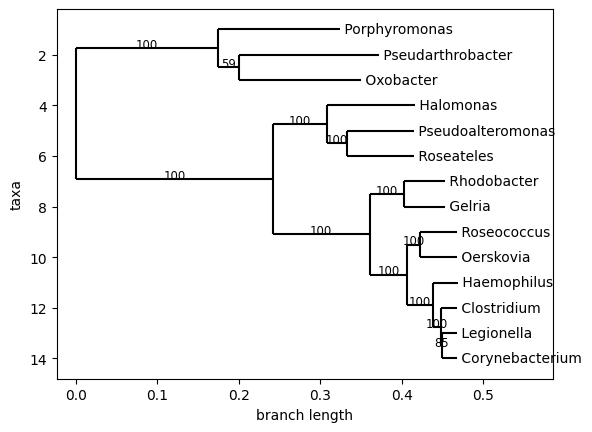

In [ ]:
from Bio.Phylo.Consensus import majority_consensus
from Bio import Phylo
# Assuming bootstrap_trees contains all your bootstrap trees

# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)  # 0.5 is the cutoff for majority rule

# Print or draw the consensus tree
print('Consensus Tree:')
print(consensus_tree)
consensus_tree.ladderize()  # Flip branches so deeper clades are displayed at top
Phylo.draw(consensus_tree)

High Confidence Clades: Clades with 100% bootstrap support, such as the one containing 'Haemophilus' and 'Legionella', are highly reliable. This indicates that these taxonomic groupings are very likely to be accurate.

Moderate Confidence Clades: The clade with a bootstrap value of 68%, containing 'Oxobacter' and 'Pseudarthrobacter', has moderate support. While this is generally considered to be a lower limit for strong support, it still suggests that this grouping is more likely to be true than not.

Taxonomic Implications: The high bootstrap values for clades containing genera like 'Haemophilus', 'Legionella', 'Roseococcus', etc., may have implications for our understanding of the relationships among these bacteria. For example, it could suggest that 'Haemophilus' and 'Legionella' share a more recent common ancestor with each other than with other genera in the tree.

Data Quality: High bootstrap values across the tree also speak to the quality of our sequence data and the alignment, suggesting that the results are not artifacts of poor data or methodology.

In [ ]:
'''# Debugging
# check the function to generate replicates
for replicate in bootstrap_replicates:
    print(replicate)
# Store the concatenated replicates in the dictionary
bootstrap_replicates[0] = concatenated_replicates

# Print first bootstrap replicate to check
print('First bootstrap replicate:', bootstrap_replicates[0])
print("Number of sequences in alignment:", len(alignment))
print("IDs of sequences in alignment:", [record.id for record in alignment])

# # Tree basic info
for i, tree in enumerate(trees):
    print(f"Tree {i}: {tree}")
from Bio.Phylo.BaseTree import Tree
#Are the trees objects?
for i, tree in enumerate(trees):
    if not isinstance(tree, Tree):
        print(f"The element at index {i} is not a Tree object.")
        # Is the trees list empty?
if not trees:
    print("The list of trees is empty.")'''

In [ ]:
# Save the tree in Newick format
Phylo.write([consensus_tree], 'data/consensus_tree.newick', 'newick')

1